In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib import cm

import datashader as ds
import plotly.express as px

from PIL import Image, ImageOps

import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterio.transform import Affine

from shapely.geometry import box

import fiona
from fiona.crs import from_epsg

import pycrs

import os

%matplotlib inline

# Read raw data and convert as GeoTIFF

In [2]:
### functions to calculate the data point to raster images

def get_max_res(bounds):
    return max((bounds[1] - bounds[0]) / 5000, 0.0002)

def get_space_coords(x_bounds, y_bounds):
    xres_max = get_max_res(x_bounds)
    yres_max = get_max_res(y_bounds)
    print(x_bounds, y_bounds)
    print("maxres x = " + str(xres_max))
    print("maxres y = " + str(yres_max))
    return np.arange(y_bounds[0], y_bounds[1], yres_max), np.arange(x_bounds[0], x_bounds[1], xres_max)

def interpolate_2d(geometry, feature, x_bounds=None, y_bounds=None):
    if not x_bounds or not y_bounds:
        raise Exception("Must provide x_bounds and y_bounds")
    
    gy, gx = np.meshgrid(*get_space_coords(x_bounds, y_bounds) )
    return griddata(geometry, feature/(feature.max()-feature.min()) , (gx, gy), method="cubic")

### Read raw gravitational data from GeoJSON files

In [3]:
### Read raw data

# x_bounds=(-124.40117, -114.00217)
# y_bounds=(32.28567, 42.11017)

x_bounds=(-13848274.90, -12690663.51)
y_bounds=(3800867.95, 5177496.69)

gdf = gpd.read_file("../../../ca_nvda_grav.geojson")

In [4]:
# Convert crs to web mercator as EPSG:3857
gdf['geometry'] = gdf['geometry'].to_crs(epsg=3857)

In [5]:
# Build 2D array from interpolation
coord_list = list(zip(gdf.geometry.x, gdf.geometry.y))

grid_1 = interpolate_2d(coord_list, gdf["isostatic_anom"].values,
                        x_bounds=x_bounds, y_bounds=y_bounds)

(-13848274.9, -12690663.51) (3800867.95, 5177496.69)
maxres x = 231.5222780000001
maxres y = 275.32574800000003


In [8]:
# replace nan values with minimum
min_value = np.nanmin(grid_1)
grid_1[np.isnan(grid_1)] = min_value

### Export as GeoTIFF file

In [9]:
### Generate transform object for GeoTiff file

# Max res of x and y, make sure tht the EPSG values are the same as above
# res_x = 0.0020797999999999975
# res_y = 0.0019648999999999986
res_x = 231.5222780000001
res_y = 275.32574800000003
transform = Affine.translation(x_bounds[0] - res_x / 2, y_bounds[0] - res_y / 2) * Affine.scale(res_x, res_y)

In [10]:
### Build GeoTiff File

with rasterio.open(
    'new_mercator_filled_all.tif',
    'w',
    driver='GTiff',
    height=grid_1.shape[0],
    width=grid_1.shape[1],
    count=1,
    dtype=grid_1.dtype,
    crs='+init=epsg:3857',
    transform=transform
) as dst:
    dst.write(grid_1, 1)

# Crop GeoTIFF with a given shapefile

In [20]:
# Masking a raster using a shapefile
# WARNING: Make sure the shapefiles has the correct EPSG value as the GeoTiff

# read mask shapefile
with fiona.open("../data/nvstateborder_shp/nvstateborder_shp.shp", "r") as shapefile:
    shapes_nv = [feature["geometry"] for feature in shapefile]

with fiona.open("../data/castateborder/CA_State_TIGER2016.shp", "r") as shapefile:
    shapes_ca = [feature["geometry"] for feature in shapefile]

In [23]:
# read raw tiff for crop
with rasterio.open("new_mercator_filled_all.tif") as src:
    out_image_ca, out_transform_ca = rasterio.mask.mask(src, shapes_ca, nodata=-9999, invert=False)
    out_meta_ca = src.meta
    
with rasterio.open("new_mercator_filled_all.tif") as src:
    out_image_nv, out_transform_nv = rasterio.mask.mask(src, shapes_nv, nodata=-9999, invert=False)
    out_meta_nv = src.meta

In [27]:
# save cropped file as tiff image
out_meta_ca.update({"driver": "GTiff",
                 "height": out_image_ca.shape[1],
                 "width": out_image_ca.shape[2],
                 "transform": out_transform_ca})

with rasterio.open("masked_ca_raster.tif", "w", **out_meta_ca) as dest:
    dest.write(out_image_ca)
    
out_meta_nv.update({"driver": "GTiff",
                 "height": out_image_nv.shape[1],
                 "width": out_image_nv.shape[2],
                 "transform": out_transform_nv})

with rasterio.open("masked_nv_raster.tif", "w", **out_meta_nv) as dest:
    dest.write(out_image_nv)

In [30]:
# Areas outside the shapefile are currently -9999
# replace all with nan to create transparency

ca_raster_tiff = rasterio.open("masked_ca_raster.tif")
ca_raster_tiff_ary = ca_raster_tiff.read(1)
ca_raster_tiff_ary[ca_raster_tiff_ary==-9999] = np.nan

nv_raster_tiff = rasterio.open("masked_nv_raster.tif")
nv_raster_tiff_ary = nv_raster_tiff.read(1)
nv_raster_tiff_ary[nv_raster_tiff_ary==-9999] = np.nan

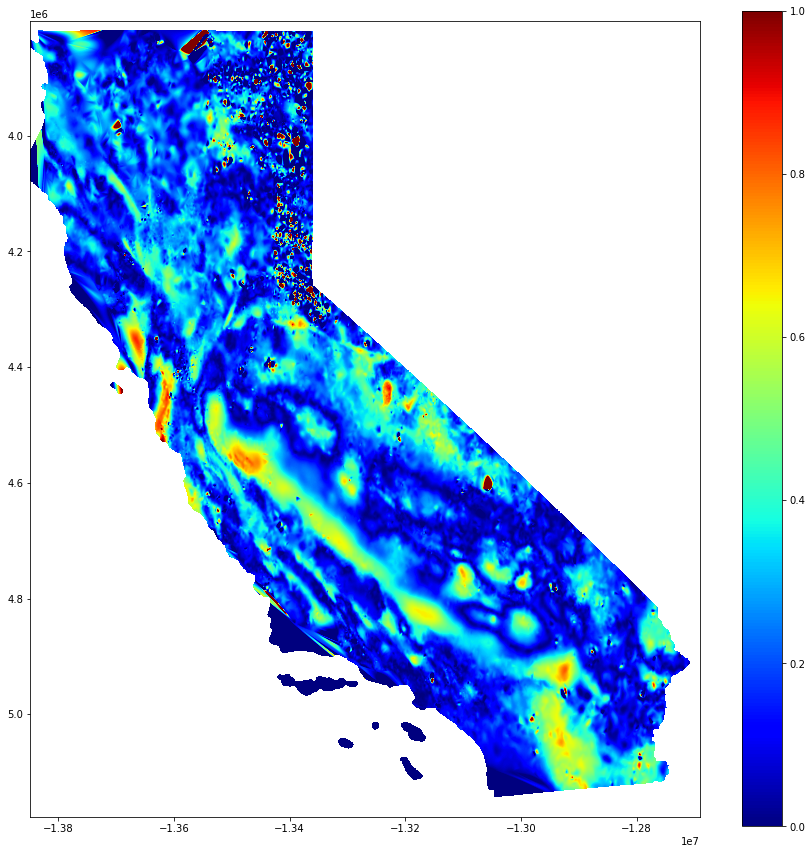

In [31]:
fig, ax = plt.subplots(figsize=(15, 15))

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(ca_raster_tiff_ary, 
                         cmap='jet', 
                         vmin=0, 
                         vmax=1,
                         origin='lower')

# plot on the same axis with rio.plot.show
image = show(ca_raster_tiff_ary, 
          transform=ca_raster_tiff.transform, 
          ax=ax, 
          cmap='jet', 
          vmin=0, 
          vmax=0.8,
          origin='lower')

# add colorbar using the now hidden image
fig.colorbar(image_hidden, ax=ax)

In [33]:
# save ndarray as png with colormap 
plt.imsave("california_raster_final.png", ca_raster_tiff_ary, cmap='jet', vmin=0, vmax=0.8)

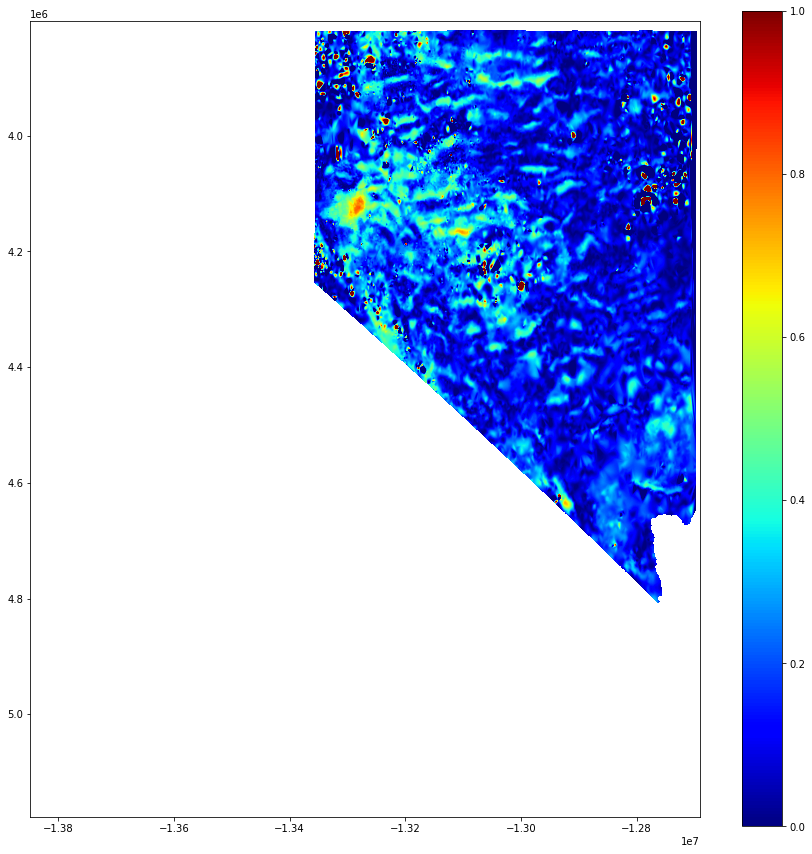

In [34]:
fig, ax = plt.subplots(figsize=(15, 15))

# use imshow so that we have something to map the colorbar to
image_hidden = ax.imshow(nv_raster_tiff_ary, 
                         cmap='jet', 
                         vmin=0, 
                         vmax=1,
                         origin='lower')

# plot on the same axis with rio.plot.show
image = show(nv_raster_tiff_ary, 
          transform=nv_raster_tiff.transform, 
          ax=ax, 
          cmap='jet', 
          vmin=0, 
          vmax=0.8,
          origin='lower')

# add colorbar using the now hidden image
fig.colorbar(image_hidden, ax=ax)

In [35]:
# save image as png with colormap 
plt.imsave("nevada_raster_final.png", nv_raster_tiff_ary, cmap='jet', vmin=0, vmax=0.8)